In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import soundfile

In [2]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/EE_769_project/TESS Toronto emotional speech set data (1)'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [3]:
## Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/MyDrive/EE_769_project/TESS Tor...,fear
1,/content/drive/MyDrive/EE_769_project/TESS Tor...,fear
2,/content/drive/MyDrive/EE_769_project/TESS Tor...,fear
3,/content/drive/MyDrive/EE_769_project/TESS Tor...,fear
4,/content/drive/MyDrive/EE_769_project/TESS Tor...,fear


In [4]:
df['label'].unique()

array(['fear', 'sad', 'happy', 'ps', 'neutral', 'angry', 'disgust'],
      dtype=object)

In [6]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

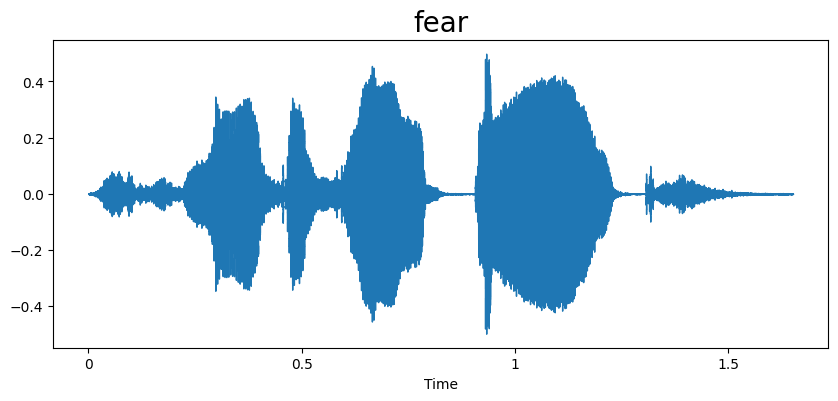

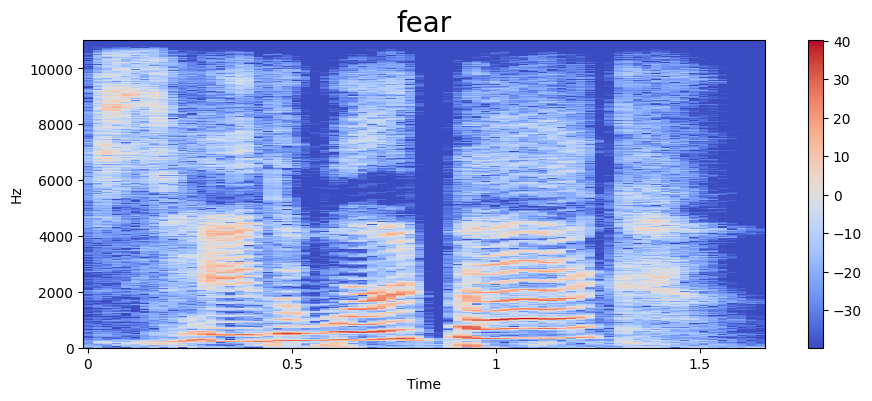

In [7]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

#New Function

In [ ]:
def extract_feature(file_name, **kwargs):
    
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")


    with soundfile.SoundFile(file_name) as sound_file:

        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate

        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])


        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
            
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))

        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))

        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))

        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))

    return result

In [ ]:
X_2 = []
y_2 = []
for i in range(0,len(df)):

    features = extract_feature(df['speech'][i], mfcc=True, chroma=True, mel=True)
    # add to data
    X_2.append(features)
    #y_2.append(df['label'][i])

In [ ]:
X_2_new = np.array(X_2)
#X_2_new = np.expand_dims(X_2_new, -1)
X_2_new.shape

(2800, 180)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_2 = enc.fit_transform(df[['label']])

In [ ]:
y_2 = y_2.toarray()
y_2.shape

(2800, 7)

#New Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2_new, y_2, test_size=0.25, random_state=7)

In [ ]:
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}

In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(**model_params)

In [ ]:
model.fit(X_train, y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [ ]:
y_pred = model.predict(X_test)

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 99.29%


In [ ]:
import joblib

joblib.dump(model, 'model_speech_recog_updated.joblib')

['model_speech_recog_updated.joblib']